In [10]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.ccgp_preference_configs import *
import scipy
import argparse
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
SAM_PAIRS_PATH = "/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle"
BL_PAIRS_PATH = "/data/patrick_res/sessions/BL/pairs_at_least_2blocks_6sess.pickle"

In [12]:
def load_res_by_dims(args, pairs):
    across_dim_res = io_utils.read_ccgp_value(args, pairs[pairs.dim_type == "across dim"], conds=["within_cond", "across_cond"], num_shuffles=0)
    across_dim_res["type"] = across_dim_res.condition + " across dim"

    within_dim_res = io_utils.read_ccgp_value(args, pairs[pairs.dim_type == "within dim"], conds=["within_cond", "across_cond"], num_shuffles=0)
    within_dim_res["type"] = within_dim_res.condition + " within dim"
    return within_dim_res, across_dim_res

### Visualize CCGP preference with no behavioral filters

Text(0.5, 1.0, 'SA CCGP of preference')

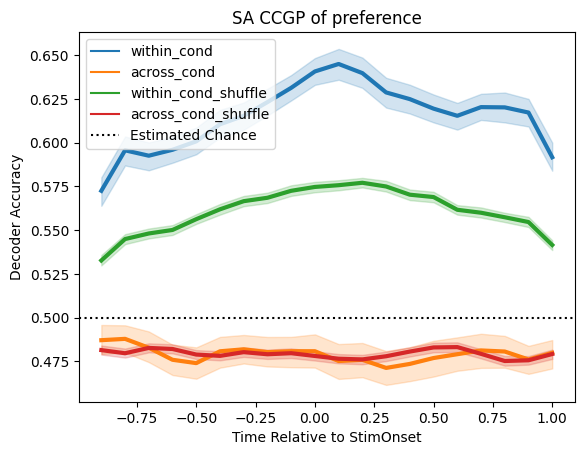

In [34]:
pairs = pd.read_pickle(SAM_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **CCGPPreferenceConfigs()._asdict()
)
args.sig_unit_level = "95th_all_time"
res = io_utils.read_ccgp_value(args, pairs, conds=["within_cond", "across_cond"])

fig, ax = plt.subplots()
visualization_utils.visualize_ccpg_value(args, res, ax)
ax.set_title("SA CCGP of preference")

Text(0.5, 1.0, 'CCGP of preference across dimensions')

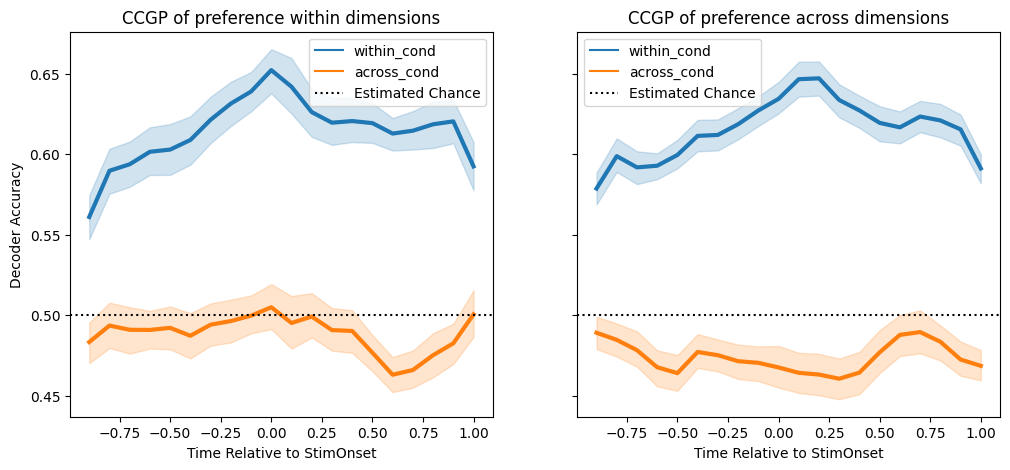

In [35]:
within, across = load_res_by_dims(args, pairs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

visualization_utils.visualize_ccpg_value(args, within, ax1)
ax1.set_title("CCGP of preference within dimensions")
visualization_utils.visualize_ccpg_value(args, across, ax2)
ax2.set_title("CCGP of preference across dimensions")

### With behavioral filters (Correct, prefered feat appears on chosen card)

Warning, shuffle not found: /data/patrick_res/ccgp_preference/SA_StimOnset_Response_Correct_PreferredChosen_True_95th_all_time_units/session_permute_shuffles/CIRCLE_RIPPLE_shuffle_3_within_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/ccgp_preference/SA_StimOnset_Response_Correct_PreferredChosen_True_95th_all_time_units/session_permute_shuffles/CIRCLE_RIPPLE_shuffle_3_across_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/ccgp_preference/SA_StimOnset_Response_Correct_PreferredChosen_True_95th_all_time_units/session_permute_shuffles/CIRCLE_RIPPLE_shuffle_4_within_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/ccgp_preference/SA_StimOnset_Response_Correct_PreferredChosen_True_95th_all_time_units/session_permute_shuffles/CIRCLE_RIPPLE_shuffle_4_across_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/ccgp_preference/SA_StimOnset_Response_Correct_PreferredChosen_True_95th_all_time_units/session_permute_shuffles/CIRCLE_RIPPLE_shuffle_9_within

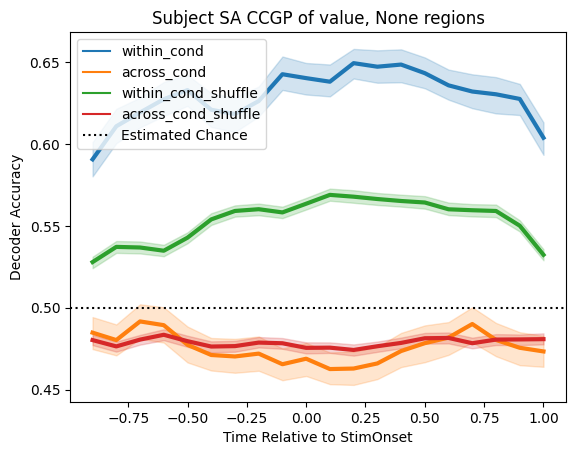

In [13]:
pairs = pd.read_pickle(SAM_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **CCGPPreferenceConfigs()._asdict()
)
args.sig_unit_level = "95th_all_time"
args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
res = io_utils.read_ccgp_value(args, pairs, conds=["within_cond", "across_cond"])

fig, ax = plt.subplots()
visualization_utils.visualize_ccpg_value(args, res, ax)


Text(0.5, 1.0, 'CCGP of preference across dimensions')

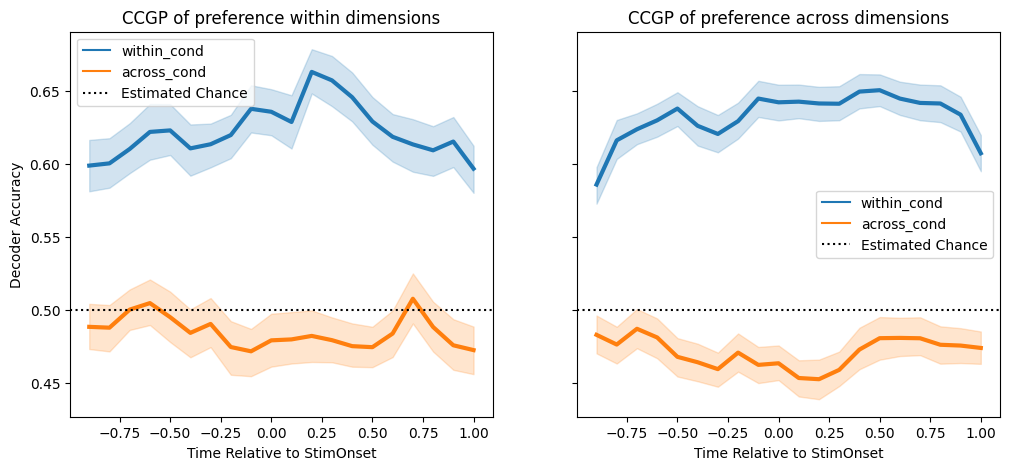

In [14]:
within, across = load_res_by_dims(args, pairs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

visualization_utils.visualize_ccpg_value(args, within, ax1)
ax1.set_title("CCGP of preference within dimensions")
visualization_utils.visualize_ccpg_value(args, across, ax2)
ax2.set_title("CCGP of preference across dimensions")

### Maybe there's a difference in cosine similarity? Read the models, evaluate

In [34]:
pairs = pd.read_pickle(SAM_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **CCGPPreferenceConfigs()._asdict()
)
args.sig_unit_level = "95th_all_time"
# args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
models = io_utils.read_ccgp_models(args, pairs)
models["weights"] = models.apply(lambda x: x.models.coef_[0, :], axis=1)
weights = models[["Time", "pair", "feat", "run", "weights"]]

In [35]:
across_res = []
within_res = []
for i, row in pairs.iterrows():
    pair_weights = weights[weights.pair.apply(lambda x: x == row.pair)]
    weights_feat_1 = pair_weights[pair_weights.feat == row.pair[0]]
    weights_feat_2 = pair_weights[pair_weights.feat == row.pair[1]]
    sim_res = classifier_utils.get_cross_cond_cosine_sim_of_weights(weights_feat_1, weights_feat_2, merge_on=["Time"])
    if row.dim_type == "across dim":
        across_res.append(sim_res)
    else:
        within_res.append(sim_res)
across_res = pd.concat(across_res)
across_res["dim_type"] = "across"
within_res = pd.concat(within_res)
within_res["dim_type"] = "within"

Text(0.5, 1.0, 'Cosine sim between pairs of feature pref decoder weights by dimension type')

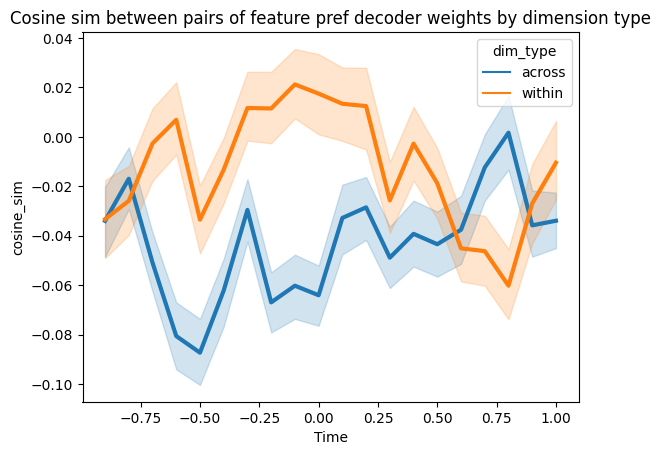

In [36]:
fig, ax = plt.subplots()
dim_sim_res = pd.concat([across_res, within_res])
sns.lineplot(dim_sim_res, x="Time", y="cosine_sim", hue="dim_type", linewidth=3, ax=ax)
ax.set_title("Cosine sim between pairs of feature pref decoder weights by dimension type")

### maybe things are more stable if we averaged decoder weights first across runs, then evaluated cosine sim, then looked across pairs/feats

In [31]:
pairs = pd.read_pickle(SAM_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **CCGPPreferenceConfigs()._asdict()
)
args.sig_unit_level = "95th_all_time"
# args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
models = io_utils.read_ccgp_models(args, pairs)
models["weights"] = models.apply(lambda x: x.models.coef_[0, :], axis=1)
weights = models[["Time", "pair", "feat", "run", "weights"]]

In [32]:
across_res = []
within_res = []

def avg_weights(group):
    arr = np.array(group.weights.tolist())
    return np.mean(arr, axis=0)

for i, row in pairs.iterrows():
    pair_weights = weights[weights.pair.apply(lambda x: x == row.pair)]
    pair_weights = pair_weights.groupby(["feat", "Time"]).apply(avg_weights).reset_index(name="weights")
    
    weights_feat_1 = pair_weights[pair_weights.feat == row.pair[0]]
    weights_feat_2 = pair_weights[pair_weights.feat == row.pair[1]]
    sim_res = classifier_utils.get_cross_cond_cosine_sim_of_weights(weights_feat_1, weights_feat_2, merge_on=["Time"])
    if row.dim_type == "across dim":
        across_res.append(sim_res)
    else:
        within_res.append(sim_res)
across_res = pd.concat(across_res)
across_res["dim_type"] = "across"
within_res = pd.concat(within_res)
within_res["dim_type"] = "within"

Text(0.5, 1.0, 'Cosine sim between pairs of feature pref decoder weights by dimension type')

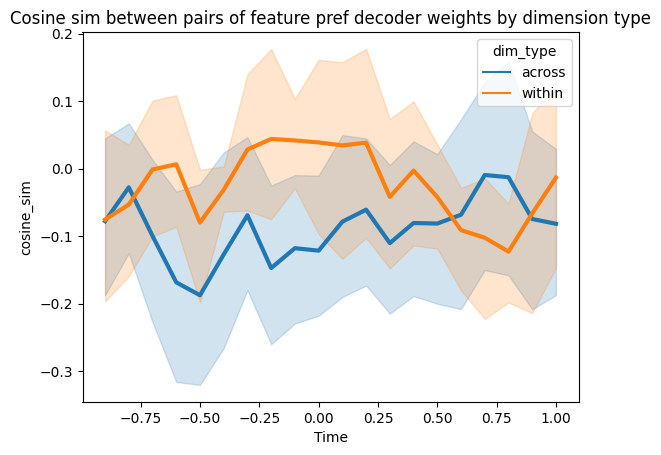

In [33]:
fig, ax = plt.subplots()
dim_sim_res = pd.concat([across_res, within_res])
sns.lineplot(dim_sim_res, x="Time", y="cosine_sim", hue="dim_type", linewidth=3, ax=ax)
ax.set_title("Cosine sim between pairs of feature pref decoder weights by dimension type")